In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# from pprint import pprint

# from sklearn.datasets import fetch_20newsgroups

import re
import nltk
from nltk.corpus import stopwords

import time
from sentence_transformers import SentenceTransformer

from PIL import Image 
import os 
import pytesseract 

In [20]:
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

path = "D:\\CS\\Research\\CCPS_Research"

In [21]:
def extract_text(path):
    data = {}
    for images in os.listdir(path):
        if images.endswith(".jpg") or images.endswith(".jpeg"):
            # print("file name: ",images)
            text = pytesseract.image_to_string(Image.open(f"{path}\\{images}"))
            # print("data: ",text)
            data[images] = text 
            
    # print("End of all file in the directory")
    # print(data)
    return data

In [22]:
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text

In [23]:
data = extract_text(path)
df = pd.DataFrame(data.items(), columns=['filename','text'])
print(df)

       filename                                               text
0  images1.jpeg  This is a handwritten\nexample\n\nWrite as goa...
1  images2.jpeg                              Gecaus es\nbe doing\n
2  images3.jpeg  \Ne Staet With Good\n\nGecause all businesses ...


In [24]:
df['text_cleaned'] = df['text'].apply(lambda text: preprocess_text(text))
df = df[df['text_cleaned'] != '']

In [25]:
st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_transformers = np.vstack(df['encode_transforemers'])

Elapsed time: 2.88 seconds


In [26]:
print(X_transformers)

[[-0.03200226  0.34872943 -0.7731296  ...  0.46779212 -0.17408255
   0.57300574]
 [ 0.07835877  0.4736254  -0.32124588 ... -0.17910622  0.17933613
   0.09741718]
 [-0.10435122 -0.20840804 -0.40547118 ... -0.80716616 -0.02120171
   0.44971478]]


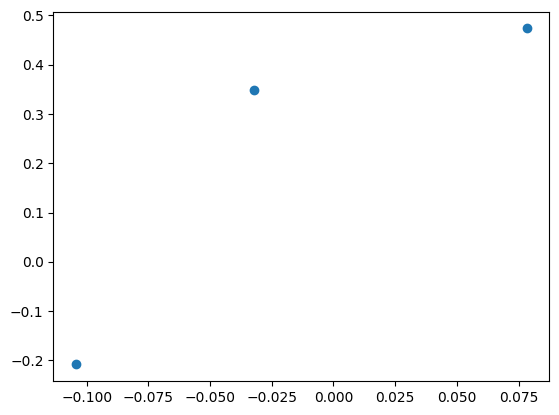

In [27]:
plt.scatter(X_transformers[:,0], X_transformers[:,1])
plt.show()

In [28]:
cl = {-1: 'k',
 0 : 'r',
 1 : 'g',
 2 : 'b',
 3 : 'c',
 4 : 'm',
 5 : 'y'}

In [29]:
from sklearn.cluster import DBSCAN 

db_default = DBSCAN().fit(X_transformers) 
db_labels = db_default.labels_

print("DBSCAN")
print(np.unique(db_default.labels_))
print(db_default.labels_)

DBSCAN
[-1]
[-1 -1 -1]


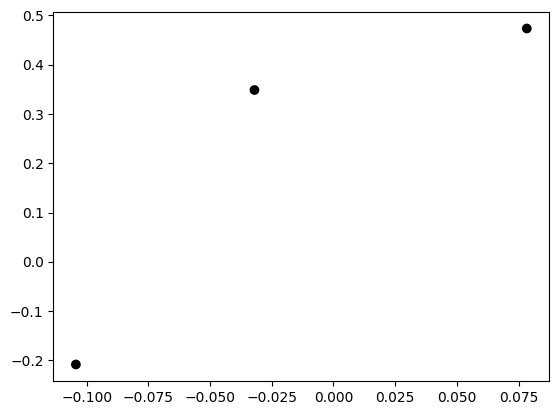

In [30]:
cvec = [cl[label] for label in db_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
plt.show()

In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_transformers)
kmeans_labels = kmeans.labels_

print("Kmeans")
print(kmeans.labels_)

Kmeans
[1 0 0]


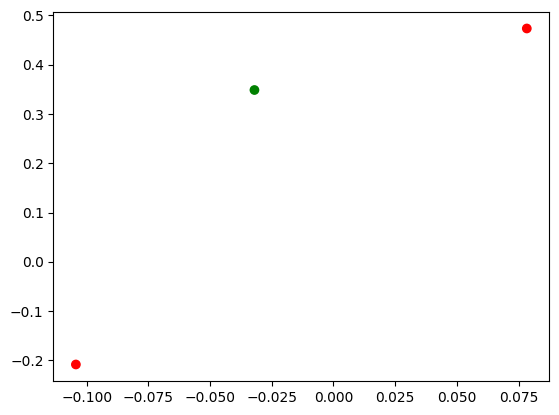

In [34]:
cvec = [cl[label] for label in kmeans_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
plt.show()

In [58]:
print("Results:\n")
dbs_result = {}
for i,j in enumerate(list(data.keys())):
    dbs_result[j] = db_default.labels_[i]
print("DBSCAN cluster: ", dbs_result, '\n')
knn_result = {}
for i,j in enumerate(list(data.keys())):
    knn_result[j] = kmeans.labels_[i]
print("KNN cluster: ", knn_result, '\n')

Results:

DBSCAN cluster:  {'images1.jpeg': -1, 'images2.jpeg': -1, 'images3.jpeg': -1} 

KNN cluster:  {'images1.jpeg': 1, 'images2.jpeg': 0, 'images3.jpeg': 0} 

